In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import interp1d
from datetime import datetime, timedelta
from datetime import timezone
import seaborn as sns
from numba import njit
sys.path.append('/home/manu/TFG_repo/scripts')

In [25]:
from config import data_dir
from analysis_routines import *
from ploting_routines import *
plt.style.use('/home/manu/TFG_repo/notebooks/notebook.mplstyle')

In [13]:
def compare_fit(df_1, df_2, temp, pres, loc):
    temp = if_masked_to_array(temp[loc])
    pres = if_masked_to_array(pres[loc])
    zz = np.linspace(0, pres[-1] + 5, 300)    
    
    fig, ax = plt.subplots(figsize=(4, 4.6875))
    ax.scatter(temp, pres, marker='o', fc='None', ec='tab:red', s=22)
    ax.axhline(df_1.iloc[loc, 3], c='grey', ls='--', label='MLD ref') # plot MLD
    ax.axhline(df_2.iloc[loc, 3], c='grey', ls=':', label='MLD ref new tol') # plot MLD
    ax.set_ylim(pres[-1] + 10, 0)
    ax.set_xlim(9.5, 18)
    ax.plot(fit_function(zz, df_1, loc), zz, ls='--', label='ref')
    ax.plot(fit_function(zz, df_2, loc), zz, label='ref new tol')
    ax.set_xlabel('Temperature (ºC)')
    ax.set_ylabel('Depth (mb)')
    ax.set_title(df_1['Dates'].iloc[loc])
    ax.legend()
    fig.tight_layout()
    plt.show()

def compare_fit_and_threshold(df_1, temp, pres, loc, threshold):
    temp_loc = if_masked_to_array(temp[loc])
    pres_loc = if_masked_to_array(pres[loc])
    zz = np.linspace(0, pres_loc[-1] + 5, 300)    
    
    fig, ax = plt.subplots(figsize=(4, 4.6875))
    ax.scatter(temp_loc, pres_loc, marker='o', fc='None', ec='tab:red', s=22)
    ax.axhline(df_1.iloc[loc, 3], c='grey', ls='--', label='MLD SHDR') # plot MLD
    ax.axhline(find_MLD_threshold(temp, pres, loc, threshold), c='grey', ls=':', label=f'MLD threshold {threshold}')
    ax.set_ylim(pres_loc[-1] + 10, 0)
    ax.set_xlim(9.5, 18)
    ax.plot(fit_function(zz, df_1, loc), zz, ls='--')
    ax.set_xlabel('Temperature (ºC)')
    ax.set_ylabel('Depth (mb)')
    ax.set_title(df_1['Dates'].iloc[loc])
    ax.legend()
    fig.tight_layout()
    plt.show()

def distance(df_fit, variable, n, value):
    '''Given variable of df_fit, return the locs where the diference between
    slices [n:] - [:-n] in that variable are greater than value.
    '''
    array = df_fit[variable].to_numpy()
    locs = np.where(abs(array[n:] - array[:-n]) > value)[0]
    ratio = len(locs)/len(df_fit)
    return locs, ratio
                    
def n_worst_profiles(df_fit, n):
    em = df_fit['em'].to_numpy()
    indices = np.argpartition(em, -n)[-n:]
    return indices

def interpolate(z, y, z_values):
    
    if isinstance(z, np.ma.core.MaskedArray):
        z = np.asarray(z[z.mask==False])
        y = np.asarray(y[y.mask==False])

    if len(z) != len(np.unique(z)):
        idx = np.argmin((z[1:] - z[:-1])) + 1
        z = np.delete(z, idx)
        y = np.delete(y, idx)
         

    interp = interp1d(z, y, 'cubic')
    idx = np.searchsorted(z, z_values)
    y = interp(z_values)
    z = z_values
    return z, y

def find_MLD_threshold(temp, pres, loc, threshold):
    zz = np.linspace(1, 175, 350)
    pres_loc, temp_loc = interpolate(pres[loc], temp[loc], zz)
    dif = temp_loc[0] - temp_loc
    a = np.searchsorted(dif, threshold)
    MLD = pres_loc[a]
    return MLD

def plot_interpolation(z, y, z_int, y_int):
    if isinstance(z, np.ma.core.MaskedArray):
        z = np.asarray(z[z.mask==False])
        y = np.asarray(y[y.mask==False])

    fig, ax = plt.subplots(figsize=(4, 4.6875))
    ax.scatter(y, z, marker='o', fc='None', ec='tab:blue', s=22)
    ax.scatter(y_int, z_int, marker='x')
    #ax.plot(y_int, z_int)
    ax.set_ylim(z[-1] + 10, 0)
    ax.set_xlim(9.5, 18)
    ax.set_xlabel('Temperature (ºC)')
    ax.set_ylabel('Depth (mb)')
    fig.tight_layout()
    plt.show()

## Limites b3

(-0.0024423062705465335, 0.0005801601151930822)
0   -0.002332
1   -0.001458
2   -0.002866
3   -0.002584
4   -0.002281
5   -0.003133
Name: b3, dtype: float64


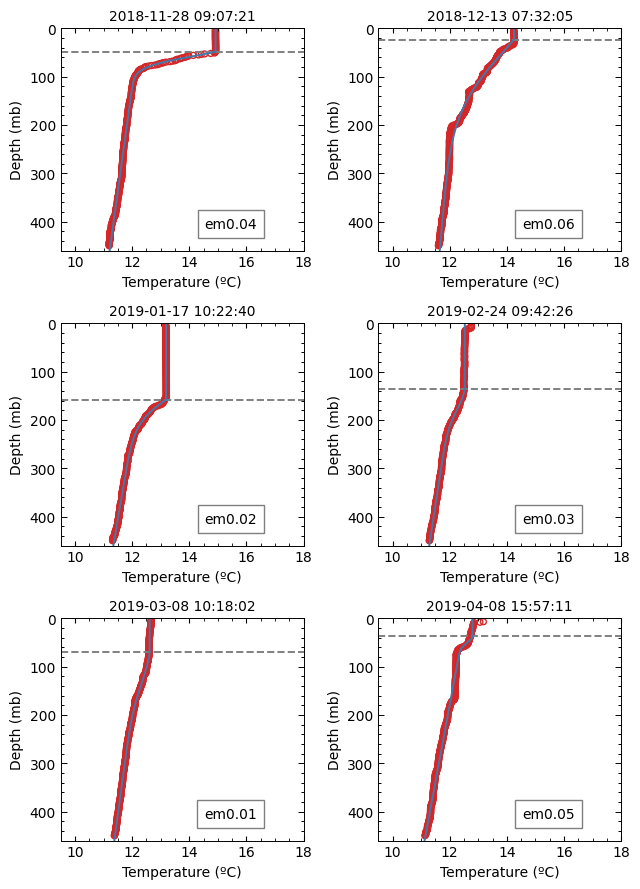

In [26]:
temp_s, pres_s, date_s = load_time_series('station7.nc')
df_station7 = load_SHDR_fit('station7_fit.csv')
print(mean_and_std(df_station7, 'b3'))
print(df_station7['b3'])
plot_multiple_profiles(df_station7, temp_s, pres_s, range(0, len(date_s)))

In [15]:
plot_fit_variable(df_cointlin, 'b3')

NameError: name 'df_cointlin' is not defined

## Problema perfiles consecutivos

In [16]:
locs, ratio = distance(df_standard, 'D1', 1, 10)
plot_multiple_profiles(df_standard, temp_1, pres_1, locs[-6:])

NameError: name 'df_standard' is not defined

In [17]:
plot_multiple_profiles(df_cointlin, temp_1, pres_1, locs[-6:])

NameError: name 'df_cointlin' is not defined

## Interpolaciones

In [22]:
n = 10
y, z = temp_1[n], pres_1[n]
z_int = np.array([13, 18, 38, 58, 68, 73, 87])
_, y_int = interpolate(z, y, z_int)

z_intmore = np.array([13, 18, 25.5, 36, 39, 46, 56.3, 59.6, 68, 73, 82, 89, 102, 117, 139.5, 163.5])
_, y_intmore = interpolate(z, y, z_intmore)

z_intlin = [13, 18, 38, 48, 58, 68, 73, 84, 90, 102, 114, 120, 131, 136, 141, 146, 156, 161, 166, 171]
_, y_intlin = interpolate(z, y, z_intlin)

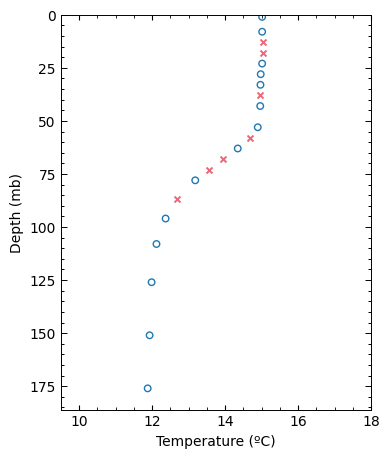

In [23]:
plot_interpolation(z, y, z_int, y_int)

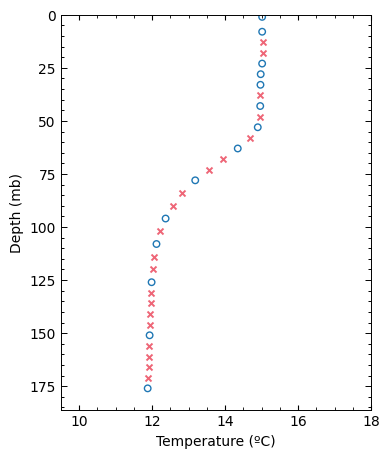

In [24]:
plot_interpolation(z, y, z_intlin, y_intlin)

### Early winter

In [20]:
temp_1, pres_1, date_1 = load_time_series('test/test_1.nc')

In [19]:
df_coint = load_SHDR_fit('SHDR_trials/test_int.csv')
print(get_fit_metadata('SHDR_trials/test_1_temporary_1.csv'))

SHDR fit for time_series = test_1.nc
FIT PROPERTIES:
continous = True
interpolation = True
delta_coding = True
b3_ref_fit = data/SHDR_fit/station7_fit.csv
FIT PARAMETRES:
cross_probability = 0.61
mutation_factor = 0.71
num_generations = 1200
max_b2_c2 = 0.2
exp_limit = 100
tol = 0.00015
seed = 111



In [18]:
df_coint = load_SHDR_fit('SHDR_trials/test_int.csv')
df_co = load_SHDR_fit('SHDR_trials/test_no_int.csv')
df_cointlin = load_SHDR_fit('SHDR_trials/test_int_linspaced.csv')
df_int = load_SHDR_fit('SHDR_trials/test_int_linspaced_no_c.csv')
df_standard = load_SHDR_fit('SHDR_trials/test_standard.csv')
df_10 = load_SHDR_fit('SHDR_trials/test_int_lins_low_b3.csv')
df_fixb3 = load_SHDR_fit('SHDR_trials/test_1_fixb3_coinlin.csv')
df_nodelta = load_SHDR_fit('SHDR_trials/test_1_nodelta_coinlin.csv')
df_fixb3_delta = load_SHDR_fit('SHDR_trials/test_1_fixb3_nodelta_coinlin.csv')
df_11 = load_SHDR_fit('SHDR_trials/test_1_temporary_3.csv')


In [67]:
## print(mean_and_std(df_cointlin, 'em'))
print(mean_and_std(df_co, 'em'))
print(mean_and_std(df_int, 'em'))
print(mean_and_std(df_standard, 'em'))
print(mean_and_std(df_fixb3, 'em'))
print(mean_and_std(df_nodelta, 'em'))
print(mean_and_std(df_fixb3_delta, 'em'))
print(mean_and_std(df_11, 'em'))

(0.07366230099181685, 0.02654407300904636)
(0.0751417671437811, 0.027693667601810776)
(0.07511293667659731, 0.027647025453454065)
(0.07549318251113497, 0.02755122639837893)
(0.0751128392486079, 0.027485765917720596)
(0.07548620849972126, 0.02755716928454863)
(0.07018683260477428, 0.02617456177757013)


In [39]:
distance_locs, ratio = distance(df_fixb3, 'D1', 1, 5)
distance_locs, ratio = distance(df_cointlin, 'D1', 1, 5)

In [19]:
locs_2 = np.where(df_nodelta['em'] > df_cointlin['em'])[0]
max_dif = np.argmin(df_nodelta['D1'] - df_cointlin['D1'])
print(len(locs_2)/len(date_1))

0.9149548708372238


In [27]:
print(len(locs_2)/len(date_1))
plot_profile_fit(df_cointlin, temp_1, pres_1, max_dif)
plot_profile_fit(df_nodelta, temp_1, pres_1, max_dif)


NameError: name 'locs_2' is not defined

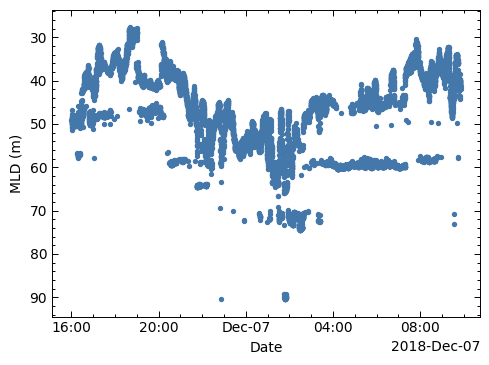

In [30]:
fig, ax = plot_fit_variable(df_standard, 'D1', plot=False)
#ax.set_ylim(67, 23)
fig.tight_layout()
plt.show()

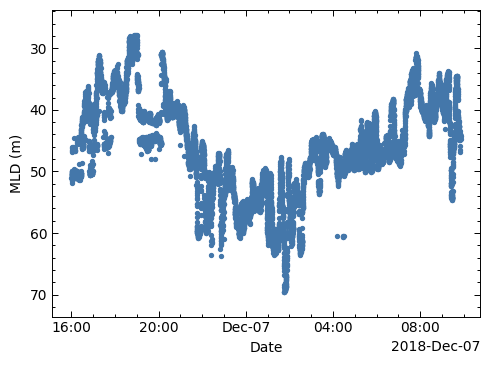

In [43]:
plot_fit_variable(df_cointlin, 'D1')

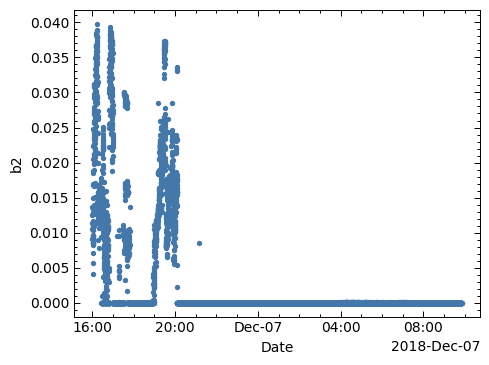

In [32]:
plot_fit_variable(df_fixb3_delta, 'b2')

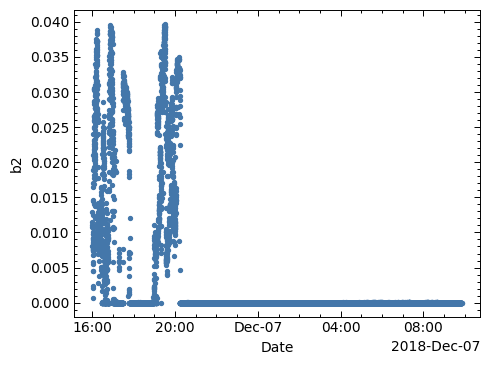

In [34]:
plot_fit_variable(df_coint, 'b2')

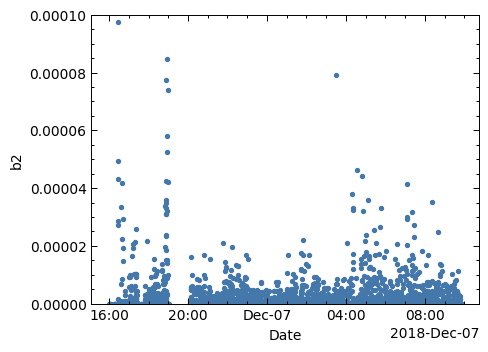

In [25]:
fig, ax = plot_fit_variable(df_cointlin, 'b2', plot=False)
ax.set_ylim(0, 0.0001)
plt.show()

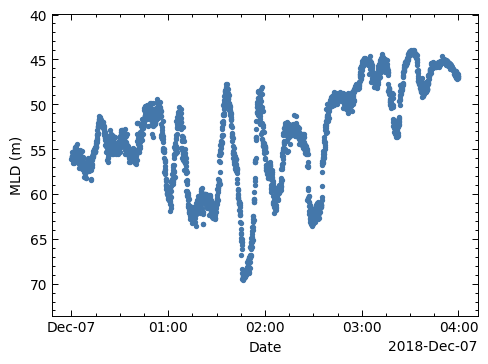

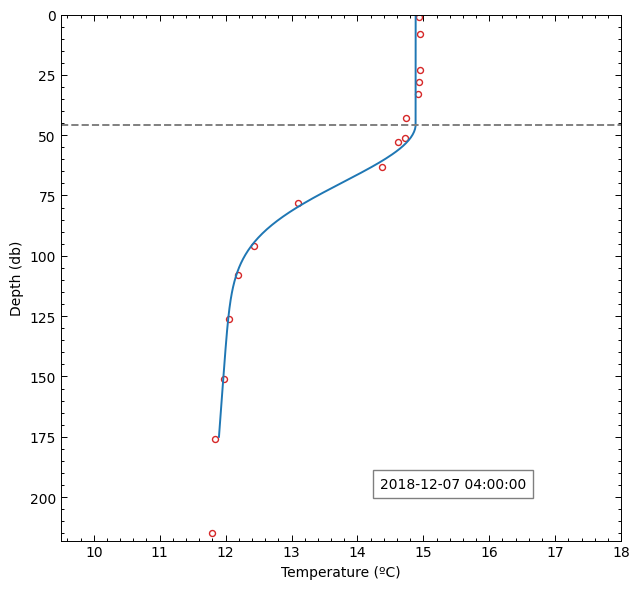

In [10]:
plot_fit_variable(df_cointlin, 'D1', lims=(datetime(2018, 12, 7), datetime(2018, 12, 7, 4)))
animate_profile_evolution(df_cointlin, temp_1, pres_1, 'ola.mp4', start_loc=datetime(2018, 12, 7), final_loc=datetime(2018, 12, 7, 4))

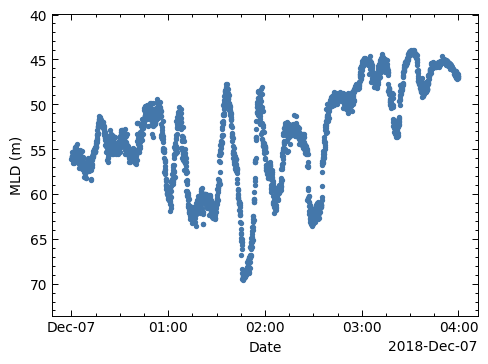

In [8]:
plot_fit_variable(df_standard, 'D1', lims=(datetime(2018, 12, 7), datetime(2018, 12, 7, 4)))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

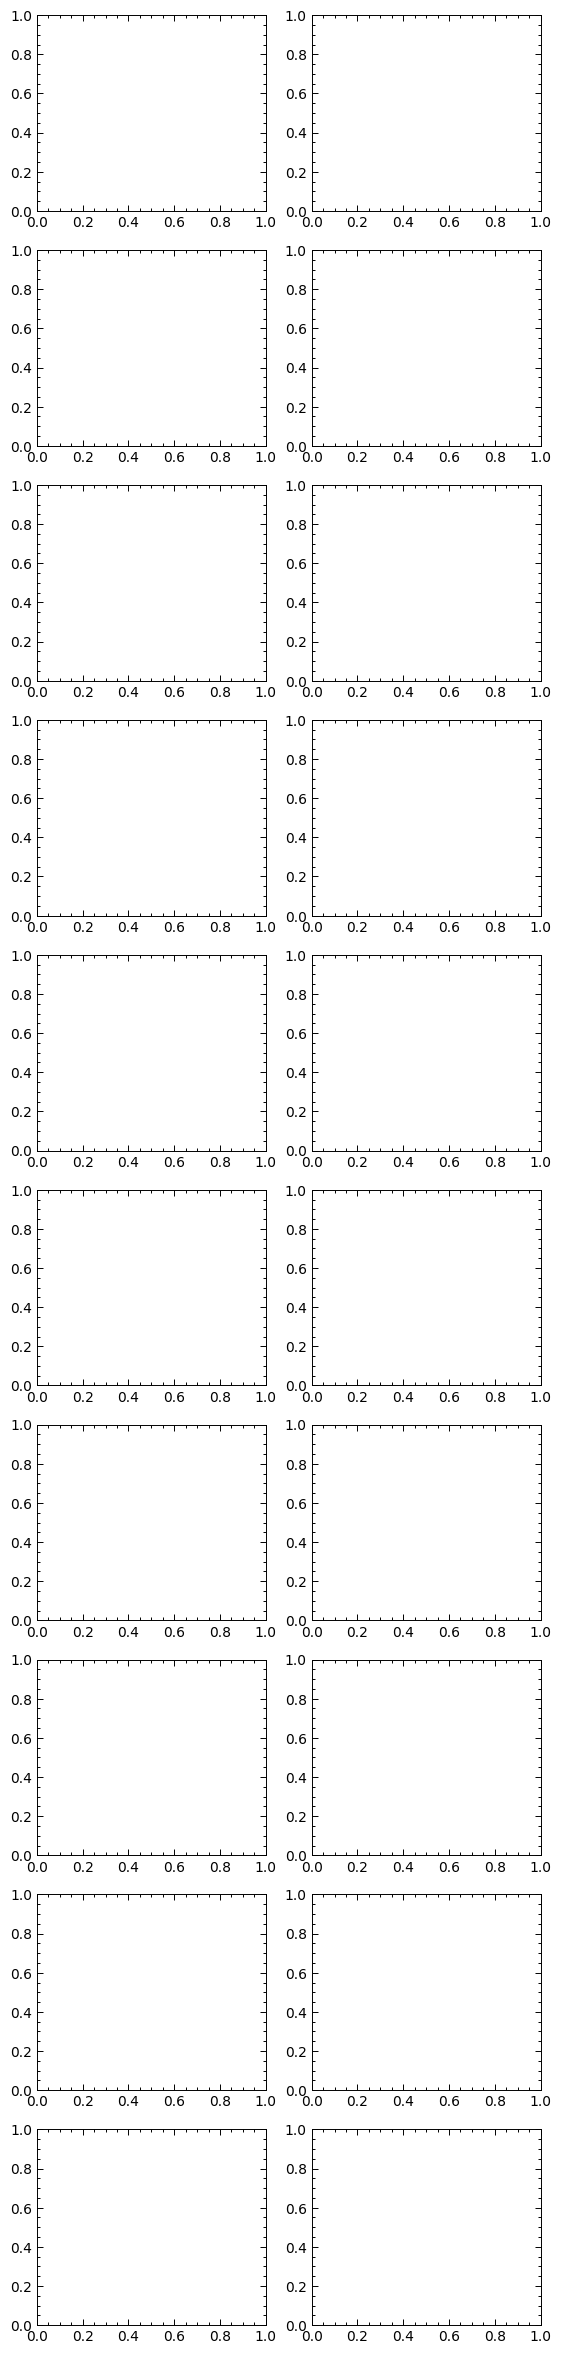

In [28]:
#plot_multiple_profiles(df_cointlin, temp_1, pres_1, range((int(len(date_1)/2), int(len(date_1)/2 + 10))
loc_1 = date_to_iloc(date_1, datetime(2018, 12, 7, 1))
loc_2 = date_to_iloc(date_1, datetime(2018, 12, 7, 3))
locs = np.linspace(loc_1, loc_2, 20)
plot_multiple_profiles(df_cointlin, temp_1, pres_1, locs)                                                    

In [25]:
mld_threshold = [find_MLD_threshold(temp_1, pres_1, i, 0.2) for i in range(len(date_1))]

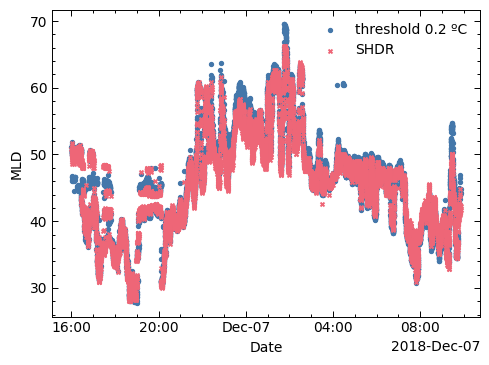

In [25]:
fig, ax = plt.subplots()
ax.scatter(date_1, df_cointlin['D1'], s=8, marker='o', label='threshold 0.2 ºC')
ax.scatter(date_1, df_fixb3['D1'], s=8, marker='x', label='SHDR')
ax.set_xlabel('Date')
ax.set_ylabel('MLD')
ax.legend()
#ax.set_ylim((max(mld_threshold) + 4, min(mld_threshold) - 4))
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
fig.tight_layout()
plt.show()

4.132005771820452 2.94430619618915


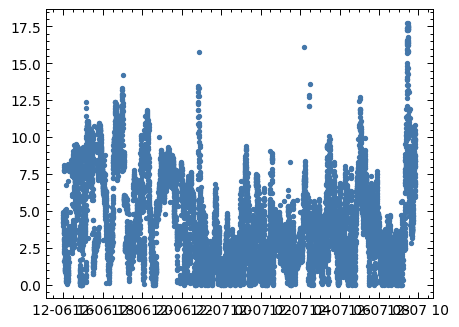

In [257]:
fig, ax = plt.subplots()
ax.scatter(date_1, abs(mld_delta - df_cointlin['D1']), s=8)
print(np.mean(abs(mld_delta - df_cointlin['D1'])), np.std(abs(mld_delta - df_cointlin['D1'])))


In [142]:
# distances
d = 10
print(f'Ratio de perfiles contiguos con una diferencia en D1 de más de {d} metros')
print('standard: {:.5f}'.format(distance(df_standard, 'D1', 1, d)[1]))
print('co: {:.5f}'.format(distance(df_co, 'D1', 1, d)[1]))
print('cointlin: {:5f}'.format(distance(df_cointlin, 'D1', 1, d)[1]))
print('coint: {:5f}'.format(distance(df_coint, 'D1', 1, d)[1]))

Ratio de perfiles contiguos con una diferencia en D1 de más de 10 metros
standard: 0.23094
co: 0.00311
cointlin: 0.000856
coint: 0.000000


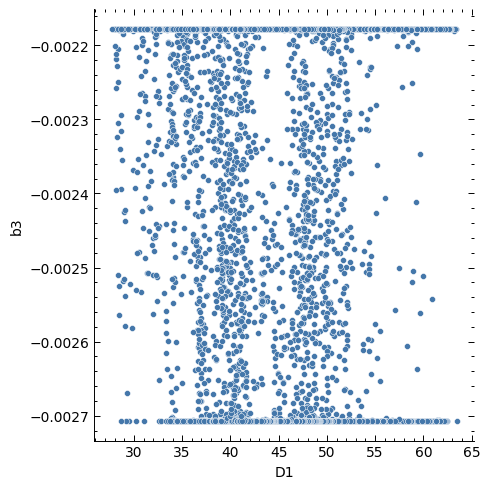

In [84]:
sns.relplot(
    data=df_coint, kind="scatter",
    x="D1", y="b3",
)
plt.show()

In [28]:
def physical_RMS(df_fit, temp, pres, loc):
    y = if_masked_to_array(temp[loc])
    z = if_masked_to_array(pres[loc])
    fitnes = np.sqrt(np.sum((y - fit_function(z, df_fit, loc))**2) / len(y))
    return fitnes


In [70]:
z_int = [13, 18, 38, 48, 58, 68, 73, 84, 90, 102, 114, 120, 131, 136, 141, 146, 156, 161, 166, 171]

dif_em = []
for i in range(len(date_1)):
    if (normal_vs_interpolated_RMS(df_11, temp_1, pres_1, z_int, i)[0] > df_standard.loc[i, 'em']):
        dif_em.append(i)

In [71]:
print(len(dif_em)/len(date_1))
print(normal_vs_interpolated_RMS(df_cointlin, temp_1, pres_1, z_int, 0))

0.8933239962651728
(0.020310203645996495, 0.017292055372503036)


## Winter

In [242]:
temp_2, pres_2, date_2 = load_time_series('test/test_winter.nc')

### todo
Igual que arriba. lininterpolated, mld interpolated, only continous
Tambien comprobar dependencia con b3 y sus límites

In [357]:
df_co = load_SHDR_fit('SHDR_trials/test_wint_co.csv')
df_cointlin_w = load_SHDR_fit('SHDR_trials/test_wint_cointlin.csv')
df_standard_w = load_SHDR_fit('SHDR_trials/test_wint_standard.csv')
df_cointlinti_w = load_SHDR_fit('SHDR_trials/test_wint_cointlintight.csv')

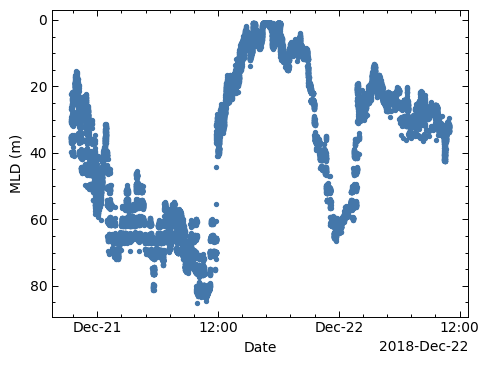

In [272]:
plot_fit_variable(df_cointlin_w, 'D1')

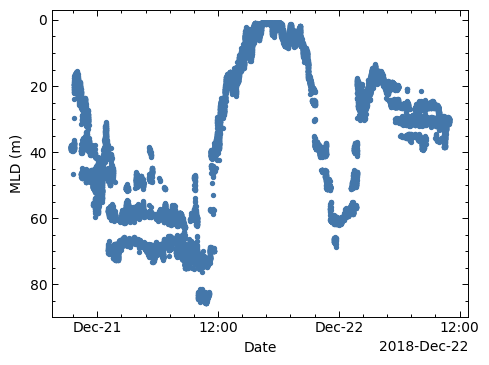

In [266]:
plot_fit_variable(df_co_w, 'D1')

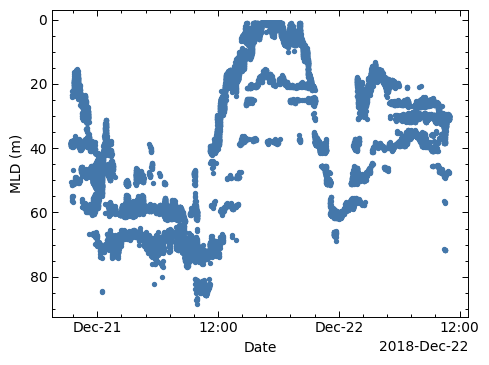

In [318]:
plot_fit_variable(df_standard_w, 'D1')

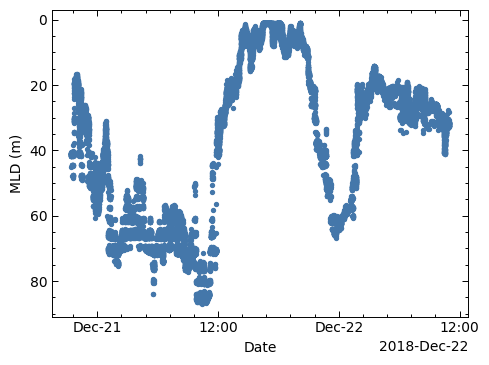

In [358]:
plot_fit_variable(df_cointlinti_w, 'D1')

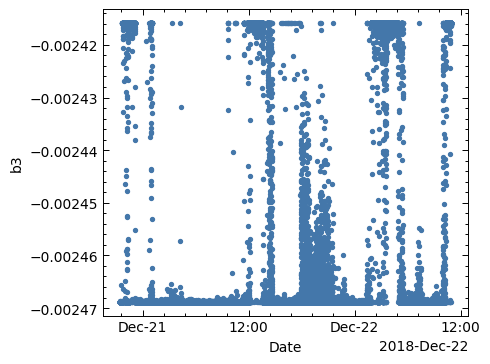

In [359]:
plot_fit_variable(df_cointlinti_w, 'b3')

In [366]:
mld_wint_threshold = np.asarray([find_MLD_threshold(temp_2, pres_2, loc, 0.2) for loc in range(len(date_2))])

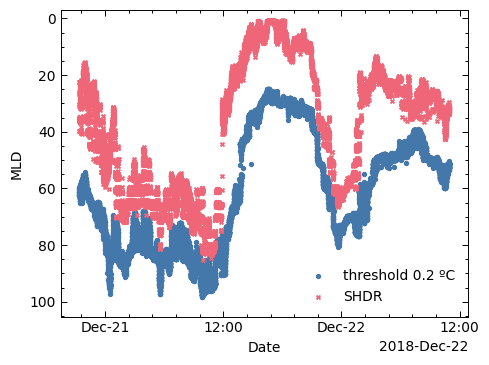

In [355]:
fig, ax = plt.subplots()
ax.scatter(date_2, mld_wint_threshold, s=8, marker='o', label='threshold 0.2 ºC')
ax.scatter(date_2, df_cointlin_w['D1'], s=8, marker='x', label='SHDR')
ax.set_xlabel('Date')
ax.set_ylabel('MLD')
ax.legend()
ax.set_ylim((max(df_cointlin_w['D1']) + 20, min(df_cointlin_w['D1']) - 4))
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
fig.tight_layout()
plt.show()

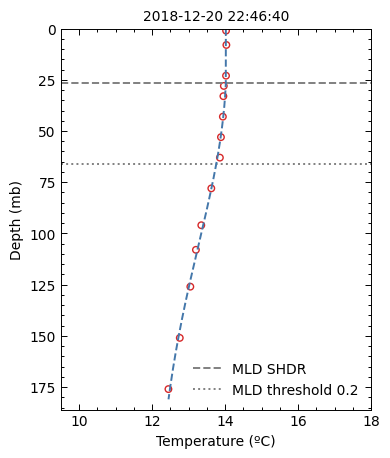

-0.0024158257053751


In [363]:
compare_fit_and_threshold(df_cointlinti_w, temp_2, pres_2, 1000, 0.2)
print(df_cointlinti_w['b3'][1000])

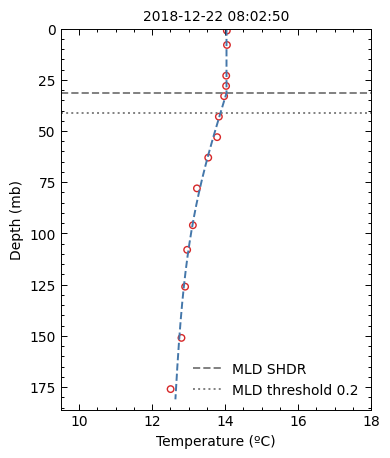

-0.0027071119222599


In [365]:
a = np.where(abs(mld_wint_threshold - df_cointlin_w['D1']) < 10)[0]
compare_fit_and_threshold(df_cointlin_w, temp_2, pres_2, a[-1], 0.2)
print(df_cointlin_w['b3'][1000])

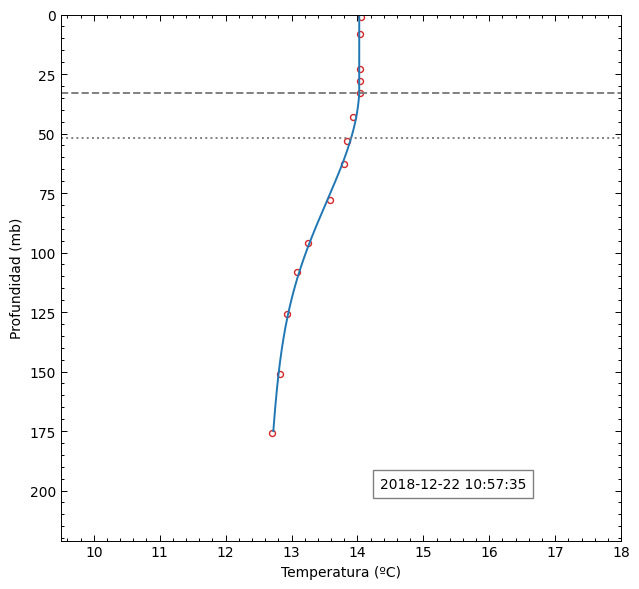

In [369]:
animate_profile_evolution(df_cointlin_w, temp_2, pres_2, 'test_wint_cointlin.mp4', optional_mld=mld_wint_threshold)

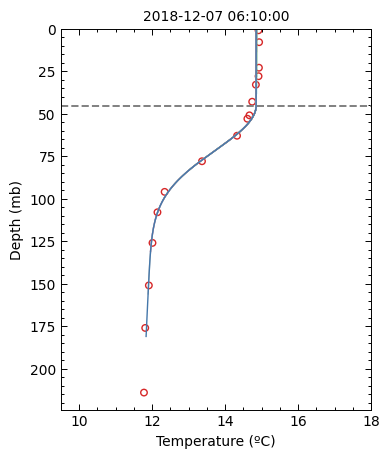

In [383]:
plot_profile_fit(df_cointlin, temp_1, pres_1, 10200)